<a href="https://colab.research.google.com/github/johntanas/it1244project/blob/main/code/model_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score,average_precision_score,SCORERS

Running this file might take a while (>1 hour) due to KNN and n_repeats=5

In [23]:
n_repeats=5
n_splits=5

In [24]:
path_to_max_label="/content/max_label.csv"
path_to_app="/content/cleaned_application.csv"
cleaned_app_df=pd.read_csv(path_to_app,index_col=0)
max_df=pd.read_csv(path_to_max_label,index_col=0)

In [25]:
dep_var="status"
random_state=42

Sort by median income of job to give a ordering to the jobs

In [26]:
order=cleaned_app_df.groupby("job")["income"].median().sort_values()

In [27]:
cleaned_app_df["job"]=cleaned_app_df["job"].replace(order)

In [29]:
train_df=max_df.merge(cleaned_app_df,how="inner",on="id").drop("id",axis=1)

In [30]:
numerical_transformer = StandardScaler()
categorical_transformer=OneHotEncoder()
ord_transformer=OrdinalEncoder()

In [31]:
X,y=train_df.drop(columns=dep_var),train_df[dep_var]

In [32]:
categorical_cols = [cname for cname in X.columns if X[cname].nunique() < 10 and 
                        X[cname].dtype == "object"]
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]


In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('ord',ord_transformer,['job'])
    ])

In [34]:
xs=preprocessor.fit_transform(X)

In [35]:
score_df=pd.DataFrame()

We will be doing cross validation with StratifiedKFold =5 and 5 repeats.
We use StratifiedKFold instead of Kfold to perserve  the percentage of samples for each class.

In [36]:
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

In [37]:
# dataframe of scores to be converted into plot later
score_df=pd.DataFrame()


* AUC is classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen. 
https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
* Thus we choose AUC as the banks who use the models can determine their own threshold risk probability for bad users and calculate their expected value/loss for these bad users and give them an appropriate interest rate when extending credit to them


There is very little linearity in the imbalanced dataset for the linear dividing line of logisitic regression to work on. This can be seen from the low level of correlation in the table below where all variables have correlation between -0.03 and 0.03 and logisitic regression will be similar to random guessing so we do not try logisitic regression

(array([0.5]), <a list of 1 Text major ticklabel objects>)

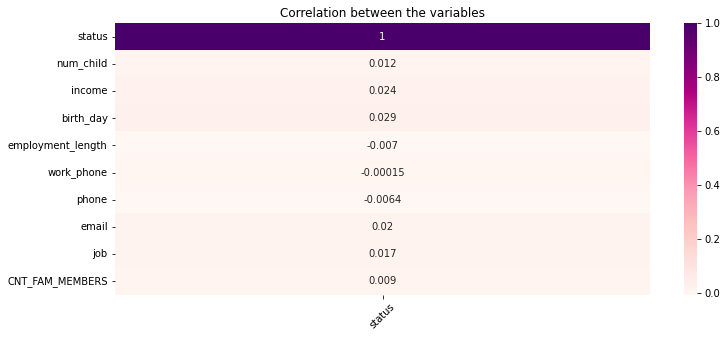

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(figsize=(12,5))
status_correlation=train_df.corr()[["status"]]
sns.heatmap(status_correlation,annot=True,cmap='RdPu')
plt.title('Correlation between the variables')
plt.xticks(rotation=45)

We cannot choose k= sqrt(len(X_train)) as it would be very hard to detect the minority class

In [ ]:
# try different K values
bestscore=0
bestmodel=None
for i in range(1,6,2):
    scores=[]
    for train_index, test_index in cv.split(xs,y):
          X_train = xs[train_index]
          y_train = y[train_index]
          X_test = xs[test_index]
          y_test = y[test_index]
          model = KNeighborsClassifier(i)
          model.fit(X_train, y_train)  
          y_pred = model.predict(X_test)
          score=roc_auc_score(y_test,y_pred)
          if score>bestscore:
              bestmodel=model
              bestscore=score
              print(f"KNN {i} with best score of {score}")
          scores.append(roc_auc_score(y_test,y_pred))
    score_df["KNN"+str(i)]=scores
    print(f"KNN {i} with avg score of {np.array(scores).median()}")

KNN 1 with best score of 0.6395611467138573
KNN 1 with best score of 0.6510423572904145
KNN 1 with best score of 0.6586509247009791


Knn with small K (1) is more able to detect the minority class in a imbalanced dataset. However, this would make this model more prone to noise

In [ ]:
bestscore=0
bestmodel=None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      model = DecisionTreeClassifier(random_state=random_state)
      model.fit(X_train, y_train )  
      y_pred = model.predict(X_test)
      score=roc_auc_score(y_test,y_pred)
      if score>bestscore:
          bestmodel=model
          bestscore=score
          print(f"DecisionTreeClassifier with best score of {score}")
      scores.append(roc_auc_score(y_test,y_pred))
score_df["DecisionTreeClassifier"]=scores
print(f"DecisionTreeClassifier with avg score of {np.array(scores).median()}")

In [ ]:
bestscore=0
bestmodel=None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      model = RandomForestClassifier(random_state=random_state,class_weight ="balanced_subsample")
      model.fit(X_train, y_train )  
      y_pred = model.predict(X_test)
      score=roc_auc_score(y_test,y_pred)
      if score>bestscore:
          bestmodel=model
          bestscore=score
          print(f"RandomForestClassifier with best score of {score}")
      scores.append(roc_auc_score(y_test,y_pred))
score_df["RandomForestClassifier"]=scores
print(f"RandomForestClassifier with avg score of {np.array(scores).median()}")

Random forests are an ensemble of decision trees and typically do better than decision trees

In [ ]:
score_df.to_csv("score.csv")

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line and it is one method to deal with imbalanced data
https://arxiv.org/abs/1106.1813

In [ ]:
# score Dataframe for model with smote 
score_df_smote=pd.DataFrame()

In [ ]:
bestscore=0
bestmodel=None
# we stop at k ==11 as it seems that the knn auc roc score drops off at k=7
for i in range(1,12,2):
    scores=[]
    for train_index, test_index in cv.split(xs,y):
        X_train = xs[train_index]
        y_train = y[train_index]
        X_test = xs[test_index]
        y_test = y[test_index]
        sm = SMOTE()
        X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
        model = KNeighborsClassifier(i)
        model.fit(X_train_oversampled, y_train_oversampled)  
        y_pred = model.predict(X_test)
        score=roc_auc_score(y_test,y_pred)
        scores.append(score)
        if score>bestscore:
            bestmodel=model
            bestscore=score
            print(f"KNN {i} with best score of {score}")
    score_df_smote["KNN"+str(i)]=scores
    print(f"KNN {i} with avg score of {np.array(scores).median()}")

Smote works by using a random example from the minority class which is first chosen. Then k of the nearest neighbors for that example are found (k=5 is the default value which is used here). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space. Thus, smote is essentially overfitting our KNN classifier
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [ ]:
bestscore=0
bestmodel=None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      sm = SMOTE()
      X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
      model = DecisionTreeClassifier(random_state=random_state)
      model.fit(X_train_oversampled, y_train_oversampled )  
      y_pred = model.predict(X_test)
      score=roc_auc_score(y_test,y_pred)
      scores.append(score)
      if score>bestscore:
            bestmodel=model
            bestscore=score
            print(f"DecisionTreeClassifier with best score of {score}")
score_df_smote["DecisionTreeClassifier"]=scores
print(f"DecisionTreeClassifier with avg score of {np.array(scores).median()}")

In [ ]:
bestscore=0
bestmodel=None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      sm = SMOTE()
      X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
      model = RandomForestClassifier(random_state=random_state)
      model.fit(X_train_oversampled, y_train_oversampled)  
      y_pred = model.predict(X_test)
      score=roc_auc_score(y_test,y_pred)
      scores.append(score)
      if score>bestscore:
            bestmodel=model
            bestscore=score
            print(f"RandomForestClassifier with best score of {score}")
score_df_smote["RandomForestClassifier"]=scores
print(f"RandomForestClassifier with avg score of {np.array(scores).median()}")

Surpisingly, smote actually deproves auc score across the trees models but improves knn , suggesting that the orginial data is quite noisy, and creating sythenic data will only add on to the noise.

In [ ]:
score_df_smote.to_csv("score_smote.csv")

Thus,we could also try totem links on knn and rf.

In [ ]:
from imblearn.under_sampling import TomekLinks

In [ ]:
#totem link dataframe
score_df_tl=pd.DataFrame()

In [ ]:
bestscore=0
bestmodel=None
scores=[]
# we stop at k ==9 as it seems that the knn auc roc score drops off at k=7
for i in range(1,10,2):
    scores=[]
    for train_index, test_index in cv.split(xs,y):
        X_train = xs[train_index]
        y_train = y[train_index]
        X_test = xs[test_index]
        y_test = y[test_index]
        tl = TomekLinks()
        X_train_undersampled, y_train_undersampled = tl.fit_resample(X_train, y_train)
        model = KNeighborsClassifier(i)
        model.fit(X_train_undersampled, y_train_undersampled)  
        y_pred = model.predict(X_test)
        score=roc_auc_score(y_test,y_pred)
        scores.append(score)
        if score>bestscore:
            bestmodel=model
            bestscore=score
            print(f"KNN {i} with best score of {score}")
    score_df_tl["KNN"+str(i)]=scores
    print(f"KNN {i} with avg score of {np.array(scores).median()}")

In [ ]:
bestscore=0
bestmodel=None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      sm = SMOTE()
      X_train_undersampled, y_train_undersampled = tl.fit_resample(X_train, y_train)
      model = RandomForestClassifier(random_state=random_state)
      model.fit(X_train_undersampled, y_train_undersampled)   
      y_pred = model.predict(X_test)
      score=roc_auc_score(y_test,y_pred)
      scores.append(score)
      if score>bestscore:
            bestmodel=model
            bestscore=score
            print(f"RandomForestClassifier with best score of {score}")
score_df_tl["RandomForestClassifier"]=scores
print(f"RandomForestClassifier with avg score of {np.array(scores).median()}")

In [ ]:
score_df_tl.to_csv("score_tl.csv")